In [1]:
# loading packages
# basic
import numpy as np
import pandas as pd
from pandas import datetime

# data visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# ML
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder
from collections import Counter
from imblearn.over_sampling import SMOTE
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline

In [3]:
#load datasets
train_buy = pd.read_csv('./train_buy_info.csv', low_memory = False)
train_cust = pd.read_csv('./train_cust_info.csv', low_memory = False)
train_tpy = pd.read_csv('./train_tpy_info.csv', low_memory = False)
test_buy = pd.read_csv('./test_buy_x_info.csv', low_memory = False)
test_cust=pd.read_csv('./test_cust_x_info.csv',low_memory=False)
test_tpy=pd.read_csv('./test_tpy_x_info.csv',low_memory=False)

In [4]:
# merge train datasets
train_buy_cust = pd.merge(train_buy, train_cust, how = 'inner', on = 'CUST_ID')
train_buy_cust_tpy=pd.merge(train_buy_cust,train_tpy, how = 'inner', on = 'CUST_ID')

In [5]:
# merge test datasets
test_buy_cust= pd.merge(test_buy, test_cust, how = 'inner', on = 'CUST_ID')
test_buy_cust_tpy= pd.merge(test_buy_cust, test_tpy, how = 'inner', on = 'CUST_ID')

In [6]:
# merge train & test datasets
train_test_all=pd.concat([train_buy_cust_tpy,test_buy_cust_tpy],axis=0)

In [7]:
# the size of train dataset
train_buy_cust_tpy.shape

(229504, 47)

In [8]:
# the size of test dataset
test_buy_cust_tpy.shape

(10000, 46)

In [9]:
# the size of train_test_all dataset
train_test_all.shape

(239504, 47)

In [10]:
# 檢視train_test_all資料集
train_test_all.head(5).append(train_test_all.tail(5))

,AGE,BEHAVIOR_1,BEHAVIOR_2,BEHAVIOR_3,BUDGET,BUY_MONTH,BUY_TPY1_NUM_CLASS,BUY_TPY2_NUM_CLASS,BUY_TPY3_NUM_CLASS,BUY_TPY4_NUM_CLASS,...,MARRIAGE,OCCUPATION,PARENTS_DEAD,REAL_ESTATE_HAVE,SEX,STATUS1,STATUS2,STATUS3,STATUS4,WEIGHT
0,d,a,b,c,-0.097277,9,E,G,G,G,...,b,q37,B,B,a,NaN,NaN,NaN,NaN,-0.069464
1,k,a,b,a,0.527346,1,D,G,G,G,...,b,i37,B,B,a,NaN,NaN,NaN,NaN,NaN
2,j,a,b,c,-0.236314,10,G,F,G,F,...,f,i37,B,B,a,NaN,NaN,NaN,NaN,-0.162807
3,f,a,b,b,-0.231325,5,D,C,G,D,...,b,r37,B,B,b,NaN,NaN,NaN,NaN,0.023878
4,h,a,b,c,-0.238327,8,G,E,G,G,...,b,r32,A,A,a,NaN,NaN,NaN,NaN,-0.396164
9995,k,a,b,c,1.052534,9,F,G,G,G,...,f,d32,A,B,a,NaN,NaN,NaN,NaN,NaN
9996,c,a,b,c,-0.246160,4,E,E,G,E,...,b,i37,B,B,b,NaN,NaN,NaN,NaN,-0.862877
9997,h,a,b,b,-0.230500,5,G,G,F,G,...,b,s32,B,A,b,NaN,NaN,NaN,NaN,0.303906
9998,g,a,b,b,-0.214644,4,E,E,G,G,...,b,i37,A,A,b,NaN,NaN,NaN,NaN,0.677277
9999,c,a,b,c,-0.245930,5,G,G,G,G,...,b,s32,B,B,a,NaN,NaN,NaN,NaN,-0.256150


In [11]:
# 檢視train_test_all各欄位之空值
train_test_all.isnull().sum()

AGE                        0
BEHAVIOR_1              5257
BEHAVIOR_2              5257
BEHAVIOR_3              6754
BUDGET                     0
BUY_MONTH                  0
BUY_TPY1_NUM_CLASS         0
BUY_TPY2_NUM_CLASS         0
BUY_TPY3_NUM_CLASS         0
BUY_TPY4_NUM_CLASS         0
BUY_TPY5_NUM_CLASS         0
BUY_TPY6_NUM_CLASS         0
BUY_TPY7_NUM_CLASS         0
BUY_TYPE               10000
BUY_YEAR                   0
CHARGE_WAY             66855
CHILD_NUM                  0
CITY_CODE                  0
CUST_ID                    0
EDUCATION                  0
HEIGHT                 17543
INTEREST1             218781
INTEREST10            218781
INTEREST2             218781
INTEREST3             218781
INTEREST4             218781
INTEREST5             218781
INTEREST6             218781
INTEREST7             218781
INTEREST8             218781
INTEREST9             218781
IS_APP                     8
IS_EMAIL                   8
IS_MAJOR_INCOME            0
IS_NEWSLETTER 

In [12]:
# 將HEIGHT, WEIGHT之空值用中位數補值
train_test_all['HEIGHT'].fillna(train_test_all['HEIGHT'].median(),inplace=True)
train_test_all['WEIGHT'].fillna(train_test_all['WEIGHT'].median(),inplace=True)

In [13]:
# 刪除太多空值以及不放入模型之欄位
train_test_all=train_test_all.drop(['STATUS1','STATUS2','STATUS3','STATUS4','INTEREST1','INTEREST2','INTEREST3','INTEREST4'
                 ,'INTEREST5','INTEREST6','INTEREST7','INTEREST8','INTEREST9','INTEREST10','IS_NEWSLETTER','CHARGE_WAY'
                                   ,'IS_PHONE','IS_EMAIL','BUY_YEAR'],axis=1)

In [14]:
train_test_all.isnull().sum()

AGE                       0
BEHAVIOR_1             5257
BEHAVIOR_2             5257
BEHAVIOR_3             6754
BUDGET                    0
BUY_MONTH                 0
BUY_TPY1_NUM_CLASS        0
BUY_TPY2_NUM_CLASS        0
BUY_TPY3_NUM_CLASS        0
BUY_TPY4_NUM_CLASS        0
BUY_TPY5_NUM_CLASS        0
BUY_TPY6_NUM_CLASS        0
BUY_TPY7_NUM_CLASS        0
BUY_TYPE              10000
CHILD_NUM                 0
CITY_CODE                 0
CUST_ID                   0
EDUCATION                 0
HEIGHT                    0
IS_APP                    8
IS_MAJOR_INCOME           0
IS_SPECIALMEMBER         29
MARRIAGE                  0
OCCUPATION                0
PARENTS_DEAD              0
REAL_ESTATE_HAVE          0
SEX                       0
WEIGHT                    0
dtype: int64

In [15]:
# 找出BEHAVIOR_1~3, IS_SPECIALMEMBER之眾數
print(train_test_all['BEHAVIOR_1'].mode())
print(train_test_all['BEHAVIOR_2'].mode())
print(train_test_all['BEHAVIOR_3'].mode())
print(train_test_all['IS_SPECIALMEMBER'].mode())

0    a
dtype: object
0    b
dtype: object
0    c
dtype: object
0    a
dtype: object


In [16]:
# 將BEHAVIOR_1~3, IS_SPECIALMEMBER之空值用眾數補值
train_test_all['BEHAVIOR_1'].fillna('a',inplace=True)
train_test_all['BEHAVIOR_2'].fillna('b',inplace=True)
train_test_all['BEHAVIOR_3'].fillna('c',inplace=True)
train_test_all['BUY_TYPE'].fillna('0',inplace=True)
train_test_all['IS_SPECIALMEMBER'].fillna('a',inplace=True)

In [17]:
# 將尚有空值之資料刪除
train_test_all=train_test_all.dropna(axis=0)

In [18]:
# 檢視剩餘資料筆數、欄位數以及各欄位之空值
print('In total:',train_test_all.shape)
train_test_all.isnull().sum()

In total: (239496, 28)


AGE                   0
BEHAVIOR_1            0
BEHAVIOR_2            0
BEHAVIOR_3            0
BUDGET                0
BUY_MONTH             0
BUY_TPY1_NUM_CLASS    0
BUY_TPY2_NUM_CLASS    0
BUY_TPY3_NUM_CLASS    0
BUY_TPY4_NUM_CLASS    0
BUY_TPY5_NUM_CLASS    0
BUY_TPY6_NUM_CLASS    0
BUY_TPY7_NUM_CLASS    0
BUY_TYPE              0
CHILD_NUM             0
CITY_CODE             0
CUST_ID               0
EDUCATION             0
HEIGHT                0
IS_APP                0
IS_MAJOR_INCOME       0
IS_SPECIALMEMBER      0
MARRIAGE              0
OCCUPATION            0
PARENTS_DEAD          0
REAL_ESTATE_HAVE      0
SEX                   0
WEIGHT                0
dtype: int64

In [19]:
pd.value_counts(train_test_all['BUY_TYPE'])

e    63510
a    63140
d    63091
c    25371
0    10000
f     6782
b     6772
g      830
Name: BUY_TYPE, dtype: int64

In [21]:
print("In total: ", train_test_all.shape)
train_test_all.head(5)

In total:  (239496, 28)


,AGE,BEHAVIOR_1,BEHAVIOR_2,BEHAVIOR_3,BUDGET,BUY_MONTH,BUY_TPY1_NUM_CLASS,BUY_TPY2_NUM_CLASS,BUY_TPY3_NUM_CLASS,BUY_TPY4_NUM_CLASS,...,HEIGHT,IS_APP,IS_MAJOR_INCOME,IS_SPECIALMEMBER,MARRIAGE,OCCUPATION,PARENTS_DEAD,REAL_ESTATE_HAVE,SEX,WEIGHT
0,d,a,b,c,-0.097277,9,E,G,G,G,...,0.290444,a,A,a,b,q37,B,B,a,-0.069464
1,k,a,b,a,0.527346,1,D,G,G,G,...,0.290444,b,A,b,b,i37,B,B,a,0.210564
2,j,a,b,c,-0.236314,10,G,F,G,F,...,0.172307,a,A,b,f,i37,B,B,a,-0.162807
3,f,a,b,b,-0.231325,5,D,C,G,D,...,0.526718,b,A,b,b,r37,B,B,b,0.023878
4,h,a,b,c,-0.238327,8,G,E,G,G,...,-0.152571,a,A,a,b,r32,A,A,a,-0.396164


In [22]:
# 檢視所有欄位
train_test_all.columns

Index(['AGE', 'BEHAVIOR_1', 'BEHAVIOR_2', 'BEHAVIOR_3', 'BUDGET', 'BUY_MONTH',
       'BUY_TPY1_NUM_CLASS', 'BUY_TPY2_NUM_CLASS', 'BUY_TPY3_NUM_CLASS',
       'BUY_TPY4_NUM_CLASS', 'BUY_TPY5_NUM_CLASS', 'BUY_TPY6_NUM_CLASS',
       'BUY_TPY7_NUM_CLASS', 'BUY_TYPE', 'CHILD_NUM', 'CITY_CODE', 'CUST_ID',
       'EDUCATION', 'HEIGHT', 'IS_APP', 'IS_MAJOR_INCOME', 'IS_SPECIALMEMBER',
       'MARRIAGE', 'OCCUPATION', 'PARENTS_DEAD', 'REAL_ESTATE_HAVE', 'SEX',
       'WEIGHT'],
      dtype='object')

In [23]:
# 選出欲做Encoder之解釋變數(X)欄位
features = [0,1,2,3,5,6,7,8,9,10,11,12,15,17,19,20,21,22,23,24,25,26]
X_label_1 = train_test_all.iloc[:,features]

In [24]:
X_label_1.shape

(239496, 22)

In [25]:
X_label_1.columns

Index(['AGE', 'BEHAVIOR_1', 'BEHAVIOR_2', 'BEHAVIOR_3', 'BUY_MONTH',
       'BUY_TPY1_NUM_CLASS', 'BUY_TPY2_NUM_CLASS', 'BUY_TPY3_NUM_CLASS',
       'BUY_TPY4_NUM_CLASS', 'BUY_TPY5_NUM_CLASS', 'BUY_TPY6_NUM_CLASS',
       'BUY_TPY7_NUM_CLASS', 'CITY_CODE', 'EDUCATION', 'IS_APP',
       'IS_MAJOR_INCOME', 'IS_SPECIALMEMBER', 'MARRIAGE', 'OCCUPATION',
       'PARENTS_DEAD', 'REAL_ESTATE_HAVE', 'SEX'],
      dtype='object')

In [26]:
# LabelEncoder
labelencoder_X = LabelEncoder()
X_label_1.iloc[:,0]=labelencoder_X.fit_transform(X_label_1.iloc[:,0])
X_label_1.iloc[:,1]=labelencoder_X.fit_transform(X_label_1.iloc[:,1])
X_label_1.iloc[:,2]=labelencoder_X.fit_transform(X_label_1.iloc[:,2])
X_label_1.iloc[:,3]=labelencoder_X.fit_transform(X_label_1.iloc[:,3])
X_label_1.iloc[:,4]=labelencoder_X.fit_transform(X_label_1.iloc[:,4])
X_label_1.iloc[:,5]=labelencoder_X.fit_transform(X_label_1.iloc[:,5])
X_label_1.iloc[:,6]=labelencoder_X.fit_transform(X_label_1.iloc[:,6])
X_label_1.iloc[:,7]=labelencoder_X.fit_transform(X_label_1.iloc[:,7])
X_label_1.iloc[:,8]=labelencoder_X.fit_transform(X_label_1.iloc[:,8])
X_label_1.iloc[:,9]=labelencoder_X.fit_transform(X_label_1.iloc[:,9])
X_label_1.iloc[:,10]=labelencoder_X.fit_transform(X_label_1.iloc[:,10])
X_label_1.iloc[:,11]=labelencoder_X.fit_transform(X_label_1.iloc[:,11])
X_label_1.iloc[:,12]=labelencoder_X.fit_transform(X_label_1.iloc[:,12])
X_label_1.iloc[:,13]=labelencoder_X.fit_transform(X_label_1.iloc[:,13])
X_label_1.iloc[:,14]=labelencoder_X.fit_transform(X_label_1.iloc[:,14])
X_label_1.iloc[:,15]=labelencoder_X.fit_transform(X_label_1.iloc[:,15])
X_label_1.iloc[:,16]=labelencoder_X.fit_transform(X_label_1.iloc[:,16])
X_label_1.iloc[:,17]=labelencoder_X.fit_transform(X_label_1.iloc[:,17])
X_label_1.iloc[:,18]=labelencoder_X.fit_transform(X_label_1.iloc[:,18])
X_label_1.iloc[:,19]=labelencoder_X.fit_transform(X_label_1.iloc[:,19])
X_label_1.iloc[:,20]=labelencoder_X.fit_transform(X_label_1.iloc[:,20])
X_label_1.iloc[:,21]=labelencoder_X.fit_transform(X_label_1.iloc[:,21])

In [27]:
# 檢視轉換完的結果
X_label_1.head(5)

,AGE,BEHAVIOR_1,BEHAVIOR_2,BEHAVIOR_3,BUY_MONTH,BUY_TPY1_NUM_CLASS,BUY_TPY2_NUM_CLASS,BUY_TPY3_NUM_CLASS,BUY_TPY4_NUM_CLASS,BUY_TPY5_NUM_CLASS,...,CITY_CODE,EDUCATION,IS_APP,IS_MAJOR_INCOME,IS_SPECIALMEMBER,MARRIAGE,OCCUPATION,PARENTS_DEAD,REAL_ESTATE_HAVE,SEX
0,3,0,1,2,8,4,6,4,6,6,...,12,3,0,0,0,1,84,1,1,0
1,10,0,1,0,0,3,6,4,6,6,...,20,0,1,0,1,1,40,1,1,0
2,9,0,1,2,9,6,5,4,5,6,...,6,2,0,0,1,5,40,1,1,0
3,5,0,1,1,4,3,2,4,3,3,...,13,2,1,0,1,1,88,1,1,1
4,7,0,1,2,7,6,4,4,6,5,...,10,1,0,0,0,1,87,0,0,0


In [28]:
#再針對欲做OneHotEncoder之欄位做OneHotEncoder
x_ohe = OneHotEncoder()
X1 = x_ohe.fit_transform(X_label_1['SEX'].values.reshape(-1,1)).toarray()
X2 = x_ohe.fit_transform(X_label_1['OCCUPATION'].values.reshape(-1,1)).toarray()
X3 = x_ohe.fit_transform(X_label_1['CITY_CODE'].values.reshape(-1,1)).toarray()
X4 = x_ohe.fit_transform(X_label_1['MARRIAGE'].values.reshape(-1,1)).toarray()
X5 = x_ohe.fit_transform(X_label_1['BEHAVIOR_1'].values.reshape(-1,1)).toarray()
X6 = x_ohe.fit_transform(X_label_1['BEHAVIOR_2'].values.reshape(-1,1)).toarray()
X7 = x_ohe.fit_transform(X_label_1['BEHAVIOR_3'].values.reshape(-1,1)).toarray()
X8 = x_ohe.fit_transform(X_label_1['BUY_MONTH'].values.reshape(-1,1)).toarray()
X9 = x_ohe.fit_transform(X_label_1['IS_APP'].values.reshape(-1,1)).toarray()
X10 = x_ohe.fit_transform(X_label_1['IS_SPECIALMEMBER'].values.reshape(-1,1)).toarray()
X11 = x_ohe.fit_transform(X_label_1['PARENTS_DEAD'].values.reshape(-1,1)).toarray()
X12 = x_ohe.fit_transform(X_label_1['REAL_ESTATE_HAVE'].values.reshape(-1,1)).toarray()
X13 = x_ohe.fit_transform(X_label_1['IS_MAJOR_INCOME'].values.reshape(-1,1)).toarray()

In [29]:
# 將所有轉換完之欄位整合
train_max=pd.concat([train_test_all['HEIGHT'],train_test_all['WEIGHT'],train_test_all['BUDGET'],
                     X_label_1['AGE'],X_label_1['EDUCATION'],
                     X_label_1['BUY_TPY1_NUM_CLASS'],train_test_all['CHILD_NUM']
                   ,X_label_1['BUY_TPY2_NUM_CLASS'],X_label_1['BUY_TPY3_NUM_CLASS'],X_label_1['BUY_TPY4_NUM_CLASS'],
                   X_label_1['BUY_TPY5_NUM_CLASS'],X_label_1['BUY_TPY6_NUM_CLASS'],X_label_1['BUY_TPY7_NUM_CLASS']],axis=1)

In [30]:
train_max.head(5)

,HEIGHT,WEIGHT,BUDGET,AGE,EDUCATION,BUY_TPY1_NUM_CLASS,CHILD_NUM,BUY_TPY2_NUM_CLASS,BUY_TPY3_NUM_CLASS,BUY_TPY4_NUM_CLASS,BUY_TPY5_NUM_CLASS,BUY_TPY6_NUM_CLASS,BUY_TPY7_NUM_CLASS
0,0.290444,-0.069464,-0.097277,3,3,4,0,6,4,6,6,6,6
1,0.290444,0.210564,0.527346,10,0,3,0,6,4,6,6,6,6
2,0.172307,-0.162807,-0.236314,9,2,6,2,5,4,5,6,4,4
3,0.526718,0.023878,-0.231325,5,2,3,0,2,4,3,3,4,4
4,-0.152571,-0.396164,-0.238327,7,1,6,0,4,4,6,5,3,3


In [31]:
train_max.shape

(239496, 13)

In [32]:
dfOneHot = pd.DataFrame(X1, columns = ["Sex_"+str(int(i)) for i in range(X1.shape[1])])
train_max.reset_index(drop=True, inplace=True)
dfOneHot.reset_index(drop=True, inplace=True)
df = pd.concat([train_max, dfOneHot], axis=1)
dfOneHot = pd.DataFrame(X2, columns = ["Occu_"+str(int(i)) for i in range(X2.shape[1])])
df = pd.concat([df, dfOneHot], axis=1)
dfOneHot = pd.DataFrame(X3, columns = ["Ci_"+str(int(i)) for i in range(X3.shape[1])])
df = pd.concat([df, dfOneHot], axis=1)
dfOneHot = pd.DataFrame(X4, columns = ["M_"+str(int(i)) for i in range(X4.shape[1])])
df = pd.concat([df, dfOneHot], axis=1)
dfOneHot = pd.DataFrame(X5, columns = ["B1_"+str(int(i)) for i in range(X5.shape[1])])
df = pd.concat([df, dfOneHot], axis=1)
dfOneHot = pd.DataFrame(X6, columns = ["B2_"+str(int(i)) for i in range(X6.shape[1])])
df = pd.concat([df, dfOneHot], axis=1)
dfOneHot = pd.DataFrame(X7, columns = ["B3_"+str(int(i)) for i in range(X7.shape[1])])
df = pd.concat([df, dfOneHot], axis=1)
dfOneHot = pd.DataFrame(X8, columns = ["BuMo_"+str(int(i)) for i in range(X8.shape[1])])
df = pd.concat([df, dfOneHot], axis=1)
dfOneHot = pd.DataFrame(X9, columns = ["App_"+str(int(i)) for i in range(X9.shape[1])])
df = pd.concat([df, dfOneHot], axis=1)
dfOneHot = pd.DataFrame(X10, columns = ["Isspe_"+str(int(i)) for i in range(X10.shape[1])])
df = pd.concat([df, dfOneHot], axis=1)
dfOneHot = pd.DataFrame(X11, columns = ["Par_"+str(int(i)) for i in range(X11.shape[1])])
df = pd.concat([df, dfOneHot], axis=1)
dfOneHot = pd.DataFrame(X12, columns = ["REH_"+str(int(i)) for i in range(X12.shape[1])])
df = pd.concat([df, dfOneHot], axis=1)
dfOneHot = pd.DataFrame(X13, columns = ["IMI_"+str(int(i)) for i in range(X13.shape[1])])
df = pd.concat([df, dfOneHot], axis=1)
df.head(10)

,HEIGHT,WEIGHT,BUDGET,AGE,EDUCATION,BUY_TPY1_NUM_CLASS,CHILD_NUM,BUY_TPY2_NUM_CLASS,BUY_TPY3_NUM_CLASS,BUY_TPY4_NUM_CLASS,...,App_0,App_1,Isspe_0,Isspe_1,Par_0,Par_1,REH_0,REH_1,IMI_0,IMI_1
0,0.290444,-0.069464,-0.097277,3,3,4,0,6,4,6,...,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
1,0.290444,0.210564,0.527346,10,0,3,0,6,4,6,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0
2,0.172307,-0.162807,-0.236314,9,2,6,2,5,4,5,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0
3,0.526718,0.023878,-0.231325,5,2,3,0,2,4,3,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0
4,-0.152571,-0.396164,-0.238327,7,1,6,0,4,4,6,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
5,-0.300242,-0.769535,-0.235426,2,1,6,0,4,4,6,...,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
6,0.290444,0.210564,-0.217920,7,1,5,0,6,4,6,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0
7,0.290444,0.210564,2.077900,13,3,5,0,6,4,6,...,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
8,0.172307,-0.069464,-0.163713,9,1,6,2,6,4,5,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
9,-2.485781,-2.123003,-0.245943,0,3,5,0,6,4,6,...,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0


In [33]:
# 檢視最終X欄位數
df.shape

(239496, 174)

In [34]:
# 將原本train, test資料拆開
X_test = df.iloc[-10000:,:]
X_train = df.iloc[0:-10000,:]

In [35]:
# 挑出目標變數Y(BUY_TYPE)
features = [13]
Buy_train = train_test_all.iloc[:,features]

In [36]:
Buy_train.shape

(239496, 1)

In [37]:
Buy_train.head(5)

,BUY_TYPE
0,a
1,a
2,d
3,e
4,f


In [38]:
Y_test = Buy_train.iloc[-10000:,:]
Y_train = Buy_train.iloc[0:-10000,:]

In [39]:
Y_train.shape

(229496, 1)

In [43]:
#SMOTE，由於目標變數Y各類別的資料筆數不平衡，因此利用SMOTE方法將它平衡
sm = SMOTE(random_state=42)
x_res, y_res = sm.fit_sample(X_train, Y_train)

C:\Users\User\Anaconda3\lib\site-packages\sklearn\utils\validation.py:547: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\utils\validation.py:547: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [44]:
#未SMOTE前
Buy_train.BUY_TYPE.value_counts()

e    63510
a    63140
d    63091
c    25371
0    10000
f     6782
b     6772
g      830
Name: BUY_TYPE, dtype: int64

In [45]:
#SMOTE之後
y_res_df = pd.DataFrame(y_res)
pd.value_counts(y_res_df[0])

d    63510
e    63510
b    63510
g    63510
f    63510
c    63510
a    63510
Name: 0, dtype: int64

In [47]:
#最終放入模型之解釋變數，共有174個變數，以及444556筆觀測值
x_res.shape

(444570, 174)

In [48]:
#最終放入模型之目標變數，共有7個變數，以及444556筆觀測值
dummy_y_res.shape

(444570, 7)

In [49]:
# define baseline model
def baseline_model():
    # create model
    model = Sequential()
    model.add(Dense(320, input_dim=174, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(7, activation='softmax'))
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [50]:
estimator = KerasClassifier(build_fn=baseline_model, epochs=100, batch_size=1000, verbose=1)

In [51]:
seed = 7
np.random.seed(seed)
kfold = KFold(n_splits=10, shuffle=True, random_state=seed)

In [52]:
results = cross_val_score(estimator, x_res,dummy_y_res, cv=kfold)
print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Epoch 1/100
400113/400113 [==============================] - 5s 13us/step - loss: 0.8466 - acc: 0.7307
Epoch 2/100
400113/400113 [==============================] - 5s 11us/step - loss: 0.4802 - acc: 0.8444
Epoch 3/100
400113/400113 [==============================] - 5s 12us/step - loss: 0.3419 - acc: 0.8842
Epoch 4/100
400113/400113 [==============================] - 5s 12us/step - loss: 0.2680 - acc: 0.9088
Epoch 5/100
400113/400113 [==============================] - 5s 12us/step - loss: 0.2312 - acc: 0.9212
Epoch 6/100
400113/400113 [==============================] - 5s 12us/step - loss: 0.2108 - acc: 0.9276
Epoch 7/100
400113/400113 [==============================] - 5s 12us/step - loss: 0.1974 - acc: 0.9312
Epoch 8/100
400113/400113 [==============================] - 5s 12us/step - loss: 0.1857 - acc: 0.9347
Epoch 9/100
400113/400113 [===

400113/400113 [==============================] - 5s 12us/step - loss: 0.0974 - acc: 0.9624
Epoch 52/100
400113/400113 [==============================] - 5s 11us/step - loss: 0.0951 - acc: 0.9633
Epoch 53/100
400113/400113 [==============================] - 5s 11us/step - loss: 0.0954 - acc: 0.9632
Epoch 54/100
400113/400113 [==============================] - 5s 11us/step - loss: 0.0970 - acc: 0.9627
Epoch 55/100
400113/400113 [==============================] - 5s 11us/step - loss: 0.0938 - acc: 0.9642
Epoch 56/100
400113/400113 [==============================] - 5s 11us/step - loss: 0.0933 - acc: 0.9638
Epoch 57/100
400113/400113 [==============================] - 5s 11us/step - loss: 0.0927 - acc: 0.9642
Epoch 58/100
400113/400113 [==============================] - 5s 11us/step - loss: 0.0939 - acc: 0.9637
Epoch 59/100
400113/400113 [==============================] - 5s 11us/step - loss: 0.0926 - acc: 0.9643
Epoch 60/100
400113/400113 [==============================] - 5s 11us/step - 

400113/400113 [==============================] - 5s 12us/step - loss: 0.2027 - acc: 0.9304
Epoch 8/100
400113/400113 [==============================] - 5s 12us/step - loss: 0.1920 - acc: 0.9335
Epoch 9/100
400113/400113 [==============================] - 5s 12us/step - loss: 0.1823 - acc: 0.9365
Epoch 10/100
400113/400113 [==============================] - 5s 12us/step - loss: 0.1753 - acc: 0.9385
Epoch 11/100
400113/400113 [==============================] - 5s 12us/step - loss: 0.1677 - acc: 0.9408
Epoch 12/100
400113/400113 [==============================] - 5s 12us/step - loss: 0.1615 - acc: 0.9426
Epoch 13/100
400113/400113 [==============================] - 5s 12us/step - loss: 0.1578 - acc: 0.9432
Epoch 14/100
400113/400113 [==============================] - 5s 12us/step - loss: 0.1530 - acc: 0.9448
Epoch 15/100
400113/400113 [==============================] - 5s 12us/step - loss: 0.1482 - acc: 0.9464
Epoch 16/100
400113/400113 [==============================] - 5s 12us/step - lo

400113/400113 [==============================] - 5s 11us/step - loss: 0.0900 - acc: 0.9651
Epoch 64/100
400113/400113 [==============================] - 5s 11us/step - loss: 0.0899 - acc: 0.9654
Epoch 65/100
400113/400113 [==============================] - 5s 11us/step - loss: 0.0889 - acc: 0.9654
Epoch 66/100
400113/400113 [==============================] - 4s 11us/step - loss: 0.0884 - acc: 0.9658
Epoch 67/100
400113/400113 [==============================] - 4s 11us/step - loss: 0.0872 - acc: 0.9663
Epoch 68/100
400113/400113 [==============================] - 4s 11us/step - loss: 0.0872 - acc: 0.9663
Epoch 69/100
400113/400113 [==============================] - 5s 11us/step - loss: 0.0882 - acc: 0.9657
Epoch 70/100
400113/400113 [==============================] - 5s 11us/step - loss: 0.0863 - acc: 0.9668
Epoch 71/100
400113/400113 [==============================] - 5s 11us/step - loss: 0.0859 - acc: 0.9666
Epoch 72/100
400113/400113 [==============================] - 5s 11us/step - 

400113/400113 [==============================] - 5s 12us/step - loss: 0.1330 - acc: 0.9497
Epoch 20/100
400113/400113 [==============================] - 5s 11us/step - loss: 0.1301 - acc: 0.9509
Epoch 21/100
400113/400113 [==============================] - 5s 12us/step - loss: 0.1266 - acc: 0.9518
Epoch 22/100
400113/400113 [==============================] - 5s 11us/step - loss: 0.1255 - acc: 0.9524
Epoch 23/100
400113/400113 [==============================] - 5s 12us/step - loss: 0.1244 - acc: 0.9526
Epoch 24/100
400113/400113 [==============================] - 5s 12us/step - loss: 0.1222 - acc: 0.9532
Epoch 25/100
400113/400113 [==============================] - 5s 12us/step - loss: 0.1211 - acc: 0.9538
Epoch 26/100
400113/400113 [==============================] - 5s 12us/step - loss: 0.1192 - acc: 0.9545
Epoch 27/100
400113/400113 [==============================] - 5s 12us/step - loss: 0.1177 - acc: 0.9550
Epoch 28/100
400113/400113 [==============================] - 5s 13us/step - 

400113/400113 [==============================] - 5s 12us/step - loss: 0.0885 - acc: 0.9655
Epoch 76/100
400113/400113 [==============================] - 5s 12us/step - loss: 0.0886 - acc: 0.9657
Epoch 77/100
400113/400113 [==============================] - 5s 12us/step - loss: 0.0868 - acc: 0.9664
Epoch 78/100
400113/400113 [==============================] - 5s 12us/step - loss: 0.0871 - acc: 0.9657
Epoch 79/100
400113/400113 [==============================] - 5s 12us/step - loss: 0.0876 - acc: 0.9657
Epoch 80/100
400113/400113 [==============================] - 5s 12us/step - loss: 0.0871 - acc: 0.9663
Epoch 81/100
400113/400113 [==============================] - 5s 12us/step - loss: 0.0863 - acc: 0.9664
Epoch 82/100
400113/400113 [==============================] - 5s 12us/step - loss: 0.0849 - acc: 0.9668
Epoch 83/100
400113/400113 [==============================] - 5s 12us/step - loss: 0.0857 - acc: 0.9667
Epoch 84/100
400113/400113 [==============================] - 5s 12us/step - 

400113/400113 [==============================] - 5s 11us/step - loss: 0.1137 - acc: 0.9568
Epoch 32/100
400113/400113 [==============================] - 4s 11us/step - loss: 0.1128 - acc: 0.9570
Epoch 33/100
400113/400113 [==============================] - 4s 11us/step - loss: 0.1119 - acc: 0.9575
Epoch 34/100
400113/400113 [==============================] - 5s 12us/step - loss: 0.1101 - acc: 0.9581
Epoch 35/100
400113/400113 [==============================] - 5s 11us/step - loss: 0.1102 - acc: 0.9579
Epoch 36/100
400113/400113 [==============================] - 5s 11us/step - loss: 0.1080 - acc: 0.9589
Epoch 37/100
400113/400113 [==============================] - 5s 11us/step - loss: 0.1082 - acc: 0.9588
Epoch 38/100
400113/400113 [==============================] - 5s 11us/step - loss: 0.1059 - acc: 0.9597
Epoch 39/100
400113/400113 [==============================] - 5s 11us/step - loss: 0.1057 - acc: 0.9598
Epoch 40/100
400113/400113 [==============================] - 5s 11us/step - 

In [59]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# train_test_split
X_train, X_val, y_train, y_val = train_test_split(x_res, y_res, test_size=0.33, random_state=42)

# 將y_train做LabelEncoder & OneHotEncoder
y_res_df = pd.DataFrame(y_train)
labelencoder_Y = LabelEncoder()
y_res_df.iloc[:,0]=labelencoder_Y.fit_transform(y_res_df.iloc[:,0])
y_ohe = OneHotEncoder()
Y = y_ohe.fit_transform(y_res_df.iloc[:,0].values.reshape(-1,1)).toarray()
dummy_y_res= pd.DataFrame(Y)

# Build model
model = Sequential()
model.add(Dense(320, input_dim=174, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(7, activation='softmax'))

# Compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train, dummy_y_res, epochs=100, batch_size=1000, verbose=1)
pred=model.predict(X_val)

df = pd.DataFrame(pred)
df['max_value'] = pred.max(axis=1)
dic = {0:'a', 1:'b', 2:'c', 3:'d', 4:'e', 5:'f', 6:'g'}
a=np.array(df)
b = np.argmax(a, axis=1)
pred_result = pd.DataFrame(b).replace(dic)
accuracy_score(pred_result, y_val)

Epoch 1/100
297861/297861 [==============================] - 4s 13us/step - loss: 0.9833 - acc: 0.6862
Epoch 2/100
297861/297861 [==============================] - 4s 12us/step - loss: 0.5627 - acc: 0.8190
Epoch 3/100
297861/297861 [==============================] - 4s 12us/step - loss: 0.4421 - acc: 0.8531
Epoch 4/100
297861/297861 [==============================] - 4s 12us/step - loss: 0.3269 - acc: 0.8879
Epoch 5/100
297861/297861 [==============================] - 4s 12us/step - loss: 0.2688 - acc: 0.9072
Epoch 6/100
297861/297861 [==============================] - 4s 12us/step - loss: 0.2384 - acc: 0.9176
Epoch 7/100
297861/297861 [==============================] - 4s 12us/step - loss: 0.2176 - acc: 0.9240
Epoch 8/100
297861/297861 [==============================] - 4s 12us/step - loss: 0.2017 - acc: 0.9292
Epoch 9/100
297861/297861 [==============================] - 4s 12us/step - loss: 0.1904 - acc: 0.9323
Epoch 10/100
297861/297861 [==============================] - 4s 12us/ste

0.9493214458554008

In [60]:
pred = model.predict(X_test)

In [64]:
pred.shape
df = pd.DataFrame(pred)
df['max_value'] = pred.max(axis=1)
dic = {0:'a', 1:'b', 2:'c', 3:'d', 4:'e', 5:'f', 6:'g'}
a=np.array(df)
b = np.argmax(a, axis=1)
pred_result = pd.DataFrame(b).replace(dic)
pred_result = pd.concat([test_buy['CUST_ID'],pred_result], axis = 1)
pred_result.columns = ['CUST_ID', 'BUY_TYPE']
pred_result

,CUST_ID,BUY_TYPE
0,2353325,e
1,1097571,d
2,2795034,a
3,48210,a
4,1582776,a
5,1123183,d
6,1510150,c
7,2177914,e
8,2423517,a
9,460160,a


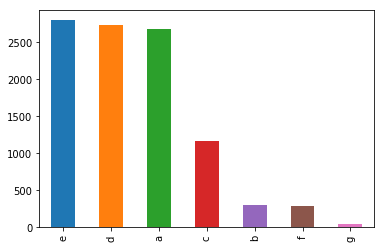

In [66]:
pred_result['BUY_TYPE'].value_counts().plot(kind='bar')

In [72]:
pred_result['BUY_TYPE'].value_counts()

e    2790
d    2724
a    2676
c    1170
b     307
f     289
g      44
Name: BUY_TYPE, dtype: int64

In [75]:
pred_result.to_csv('C:/Users/User/Desktop/pred_result.csv')